# Analyse of highly mutated samples (long branch support) in cef experiment

We noticed from the trees that despite most of the branch bein very short due to the proximity of all samples, three samples have distinctively longer branches. We want to investigate why thesesamples are so different from the others.

In [1]:
!conda install -y pandasql
!conda install -y -c conda-forge seaborn 

Fetching package metadata ...........
Solving package specifications: ..........

Package plan for installation in environment /opt/conda/envs/python2:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pandasql-0.7.3             |           py27_0          26 KB

The following NEW packages will be INSTALLED:

    pandasql: 0.7.3-py27_0

Fetching packages ...
pandasql-0.7.3 100% |################################| Time: 0:00:00   9.36 MB/s
Extracting packages ...
[      COMPLETE      ]|###################################################| 100%
Linking packages ...
[      COMPLETE      ]|###################################################| 100%
Fetching package metadata ...........
Solving package specifications: ..........

Package plan for installation in environment /opt/conda/envs/python2:

The following packages will be downloaded:

    package                    |            build
    -

In [6]:
import pandas as pd
from pandasql import *
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
from Bio import SeqIO

In [4]:
pysqldf = lambda q: sqldf(q, globals())


We start with importing the collapsed collection of snpsift output files and replacing caracters that could cause problems in the future analysis.

In [3]:
collapsed_all = pd.read_table(get(1766))
var=collapsed_all.rename(index=str, columns={"EFF[*].CODON":"CODON","EFF[*].GENE":"GENE","EFF[*].EFFECT":"EFFECT","EFF[*].EFFECT":"EFFECT","EFF[*].AA":"AA","EFF[*].IMPACT":"IMPACT","EFF[*].IMPACT.1":"IMPACT1", "EFF[*].FUNCLASS" :"FUNCLASS"})
var['condition']="NaN"
for i, row in var.iterrows() :
    var.loc[i,('condition')]=row['Sample'].split('_')[1].replace(".fq","")
    

We import the reference genbank file to get the functionnal information about the gene impacted by the variants.

In [7]:

# get all sequence records for the specified genbank file
recs = [rec for rec in SeqIO.parse(get(169), "genbank")]


We parse the file to add information about the gene product in the dataframe

In [8]:
dicFunctAll={}
for rec in recs:
    feats = [feat for feat in rec.features if feat.type == "CDS"]
    for feat in feats:
        dicFunctAll[feat.qualifiers['locus_tag'][0]]=feat.qualifiers['product'][0]

var["product"]="NaN"
for i, row in var.iterrows() :
    locusTag=row['GENE'].split(",")[0]
    if locusTag in dicFunctAll.keys():
        var.loc[i,('product')]=dicFunctAll[locusTag]

Let's take a look at our data : we now have a collumn product containing the annotation information got from the genbank file.

In [9]:
var.head()

,Sample,CHROM,POS,REF,ALT,QUAL,SAF,SAR,SRF,SRR,...,DP,EFF[*].GENEID,GENE,EFFECT,AA,IMPACT,FUNCLASS,SB,condition,product
0,SRR5363633_wtP.fq,NC_008463,41753,TCGG,CCGA,1569.14,118,84,0,0,...,202,.,PA14_00490,synonymous_variant,p.209/c.621_624delTCGGinsCCGA,LOW,NONE,0.0,wtP,hemolysin activation/secretion protein
1,SRR5363633_wtP.fq,NC_008463,72440,T,C,12141.90,232,147,0,0,...,379,.,PA14_00740,missense_variant,p.Lys132Glu/c.394A>G,MODERATE,MISSENSE,0.0,wtP,lipoprotein
2,SRR5363633_wtP.fq,NC_008463,96307,A,C,11087.10,94,247,0,0,...,341,.,PA14_00970,synonymous_variant,p.Pro49Pro/c.147T>G,LOW,SILENT,0.0,wtP,hypothetical protein
3,SRR5363633_wtP.fq,NC_008463,96350,TTGTCCAGCGT,CTGGCCCGCGC,9875.42,97,150,0,0,...,250,.,PA14_00970,missense_variant,p.ThrLeuAspAsn32AlaArgAlaSer/c.94_104delACGCTG...,MODERATE,NONE,0.0,wtP,hypothetical protein
4,SRR5363633_wtP.fq,NC_008463,96391,ACA,GCC,7932.23,108,145,0,0,...,253,.,PA14_00970,missense_variant,p.Cys21Gly/c.61_63delTGTinsGGC,MODERATE,NONE,0.0,wtP,hypothetical protein


Let's now explore our data. We start by creating a sub sample of the dataframe containing only the conditions we want to explore for easier manupulation.


In [10]:
interestCond=pysqldf("SELECT * FROM var WHERE condition='cef' AND SB<2")

Let's count how many genes and positions are affected by sample.

Sample
SRR5363684_cef.fq     72
SRR5363685_cef.fq     75
SRR5363686_cef.fq     74
SRR5363687_cef.fq     72
SRR5363688_cef.fq     74
SRR5363689_cef.fq    154
SRR5363690_cef.fq     72
SRR5363691_cef.fq    176
SRR5363692_cef.fq     81
SRR5363693_cef.fq     76
Name: GENE, dtype: int64


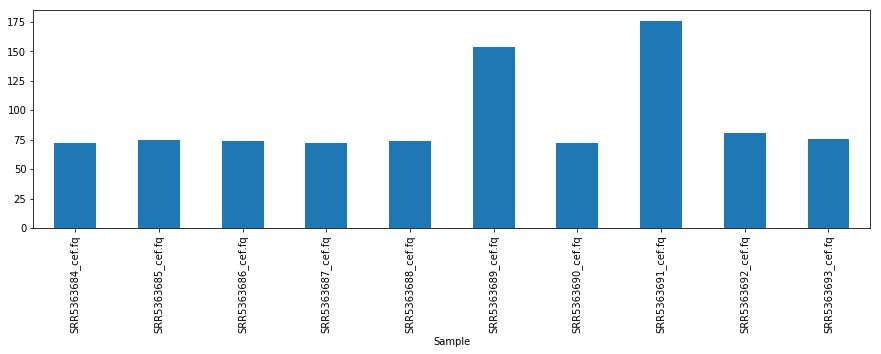

In [13]:
print pysqldf("SELECT * FROM interestCond WHERE condition='cef'").groupby("Sample")['GENE'].nunique()
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 4) )  # create figure & 1 axis
pysqldf("SELECT * FROM interestCond WHERE condition='cef'").groupby("Sample")['GENE'].nunique().plot.bar()
display(fig)

Sample
SRR5363684_cef.fq    201
SRR5363685_cef.fq    203
SRR5363686_cef.fq    195
SRR5363687_cef.fq    199
SRR5363688_cef.fq    198
SRR5363689_cef.fq    309
SRR5363690_cef.fq    201
SRR5363691_cef.fq    320
SRR5363692_cef.fq    213
SRR5363693_cef.fq    204
Name: POS, dtype: int64


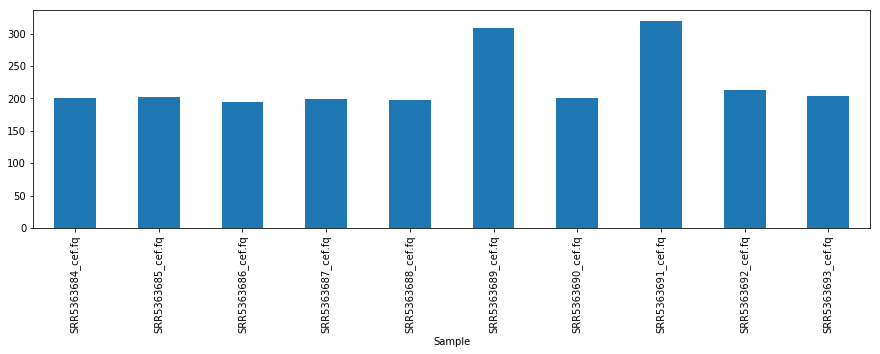

In [14]:
print pysqldf("SELECT * FROM interestCond WHERE condition='cef'").groupby("Sample")['POS'].nunique()
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 4) )  # create figure & 1 axis
pysqldf("SELECT * FROM interestCond WHERE condition='cef'").groupby("Sample")['POS'].nunique().plot.bar()
display(fig)

We can see that our two samples of interest have a much larger number of variants and gene affected, while the other samples have about the same number of variants. We also notice that SRR5363689_cef and SRR5363691_cef have similar number of variants despite not clustering together on the tree.

Let's  continue our exploration.

Let's remove the variants that are present in the wild type and control to keep onlyt the variants that could be linked to the antibiotic resistance.

In [15]:
controlvarPOS=pysqldf("SELECT * FROM var WHERE condition IN ('wtP','con') ")['POS'].unique()
controlvarPOS=[str(x) for x in controlvarPOS] 
interestingVar=pysqldf("SELECT * FROM interestCond WHERE POS NOT IN ("+','.join(controlvarPOS)+")")


Let's now take a look at the remaining variants

Sample
SRR5363684_cef.fq      7
SRR5363685_cef.fq     12
SRR5363686_cef.fq      8
SRR5363687_cef.fq      6
SRR5363688_cef.fq      7
SRR5363689_cef.fq    131
SRR5363690_cef.fq      5
SRR5363691_cef.fq    148
SRR5363692_cef.fq     21
SRR5363693_cef.fq     14
Name: POS, dtype: int64


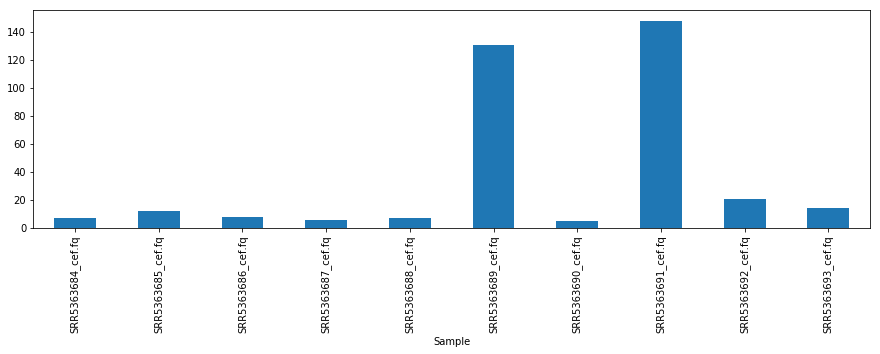

In [16]:
print pysqldf("SELECT * FROM interestingVar").groupby("Sample")['POS'].nunique()
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 4) )  # create figure & 1 axis
pysqldf("SELECT * FROM interestingVar").groupby("Sample")['POS'].nunique().plot.bar()
display(fig)

Sample
SRR5363684_cef.fq      5
SRR5363685_cef.fq      8
SRR5363686_cef.fq      8
SRR5363687_cef.fq      6
SRR5363688_cef.fq      7
SRR5363689_cef.fq     93
SRR5363690_cef.fq      4
SRR5363691_cef.fq    115
SRR5363692_cef.fq     14
SRR5363693_cef.fq     10
Name: GENE, dtype: int64


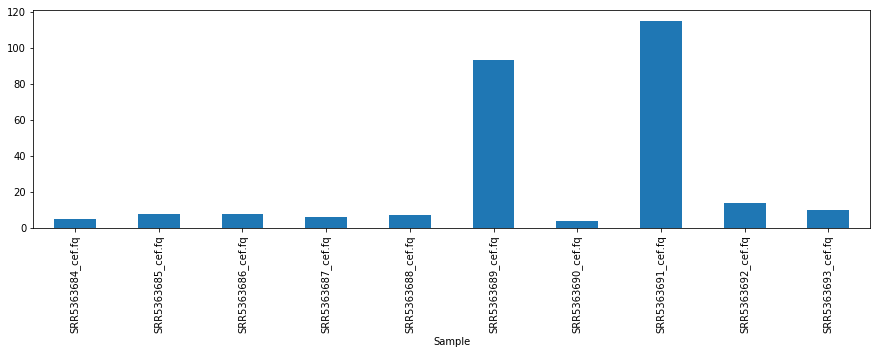

In [17]:
print pysqldf("SELECT * FROM interestingVar").groupby("Sample")['GENE'].nunique()
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 4) )  # create figure & 1 axis
pysqldf("SELECT * FROM interestingVar").groupby("Sample")['GENE'].nunique().plot.bar()
display(fig)

We can se that when the other samples have few variations, SRR5363689_cef and SRR5363691_cef have about 150 variants affectig about 120 genes. Let's see if they are affecting the same genes.


In [18]:
interestingVar['Sample'].unique()

array([u'SRR5363684_cef.fq', u'SRR5363685_cef.fq', u'SRR5363686_cef.fq',
       u'SRR5363687_cef.fq', u'SRR5363688_cef.fq', u'SRR5363689_cef.fq',
       u'SRR5363690_cef.fq', u'SRR5363691_cef.fq', u'SRR5363692_cef.fq',
       u'SRR5363693_cef.fq'], dtype=object)

In [19]:
varA=pysqldf("SELECT * FROM interestingVar WHERE Sample='SRR5363689_cef.fq'")
varB=pysqldf("SELECT * FROM interestingVar WHERE Sample='SRR5363691_cef.fq'")

In [20]:
commonVarGenes =  list(set(varB['GENE'].unique()).intersection(varA['GENE'].unique())) #Intersection of gene list between the two samples.
commonVarGenes=[str(x) for x in commonVarGenes] 
commonVarProduct=[dicFunctAll[x] for x in commonVarGenes if x in dicFunctAll.keys()] 
print commonVarGenes
print commonVarProduct

['PA14_29690', '.', 'PA14_40260', 'PA14_43190', 'PA14_46640', 'PA14_48600', 'PA14_22730']
['hypothetical protein', 'hypothetical protein', 'oxidoreductase', 'siderophore receptor', 'AMP-binding protein', 'two-component sensor']


We can see that among the 120 gene affected in each sample, they only have 7 genes in common. This result explain why they don't cluster together on the clustering tree. 

This also show that the variants outside of this list are unlikely to be linked to antibiotic resistance. 

We are now interested in knowing why these variants show such a high level of mutations.
We now want to look at the gene affected to find which could have caused these mutations.

In [21]:
varA['product'].unique()

array([u'TssG1', u'NaN',
       u'monofunctional biosynthetic peptidoglycan transglycosylase',
       u'tail fiber protein', u'hypothetical protein', u'MFS transporter',
       u'transcription antitermination protein NusB', u'protein kinase',
       u'(dimethylallyl)adenosine tRNA methylthiotransferase',
       u'nitrite extrusion protein 1',
       u'PTS system N-acetylglucosamine-specific IIBC component',
       u'chemotaxis transducer',
       u'chemotaxis sensor/effector fusion protein',
       u'tetrahydrodipicolinate succinylase', u'ribonuclease HII',
       u'DNA mismatch repair protein MutS', u'transcriptional regulator',
       u'phosphonate ABC transporter permease', u'two-component sensor',
       u'heat-shock protein IbpA', u'pilus assembly protein',
       u'oxidoreductase', u'magnesium chelatase',
       u'precorrin-3 methylase CobJ',
       u'LysR family transcriptional regulator',
       u'phenylalanyl-tRNA synthetase subunit beta',
       u'NADH dehydrogenase, FAD-cont

In [22]:
varB['product'].unique()

array([u'epsilon subunit of malonate decarboxylase',
       u'ArsR family transcriptional regulator',
       u'deoxyribonucleotide triphosphate pyrophosphatase',
       u'methylesterase', u'hypothetical protein',
       u'phosphate transporter', u'NaN', u'two-component sensor',
       u'transmembrane sensor', u'outer membrane protein',
       u'nucleoid-associated protein NdpA', u'enoyl-CoA hydratase',
       u'bifunctional UDP-glucuronic acid decarboxylase/UDP-4-amino-4-deoxy-L-arabinose formyltransferase',
       u'ATP-dependent RNA helicase',
       u'5-methylaminomethyl-2-thiouridine methyltransferase',
       u'MFS transporte', u'ATP-dependent helicase',
       u'short chain dehydrogenase',
       u'AraC family transcriptional regulator',
       u'TonB-dependent receptor', u'recombination associated protein',
       u'oxidoreductase', u'sodium/glutamate symporter', u'hydrolase',
       u'LysR family transcriptional regulator',
       u'O-succinylhomoserine sulfhydrylase',
       u

On the sample SRR5363689_cef , a potential candidate to explain the high mutation number observed is the protein PA14_17500, coding for a recombination associated protein. 

An gene ortholog to PA14_17500 Pseudomonas aeruginosa PAO1, a RdgC protein, as been shown to be a potential negative regulator of RdgA proteins, involved in  nonmutagenic repairs of stalled replication forks in bacteria (Drees et al. 2006; Ha et al. 2007). 

Nonmutagenic repair of stalled replication forks is a mecanism that allows the resolve stalled replication forks at site of DNA dammage without leaving a mutation site, by repairing the lesion through a recombination process (Cox 2002). A higher downregulation of this mecanism could lead to the accumulation of DNA damage in the genome. 

In [23]:
pysqldf("SELECT * FROM var WHERE product='recombination associated protein' AND SB<2")

,Sample,CHROM,POS,REF,ALT,QUAL,SAF,SAR,SRF,SRR,...,DP,EFF,GENE,EFFECT,AA,IMPACT,FUNCLASS,SB,condition,product
0,SRR5363691_cef.fq,NC_008463,1895926,C,G,4.238570e-14,1,1,2,5,...,9,.,PA14_21790,missense_variant,p.Arg81Pro/c.242G>C,MODERATE,MISSENSE,0.75,cef,recombination associated protein
1,SRR5363692_cef.fq,NC_008463,1896086,C,A,1.916620e-14,1,1,2,5,...,9,.,PA14_21790,stop_gained,p.Glu28*/c.82G>T,HIGH,NONSENSE,0.75,cef,recombination associated protein


It is interesting to note that another sample, SRR5363692_cef.fq, presents a variation of this gene without the high mutation rate. This could be explained by the fact that in the later, the mutation caused the apparition of a stop codon, likely rendering the protein inactive, whereas the variation in SRR5363691_cef could have increased its efficiency. 


On the second sample SRR5363689_cef : the candidate as a responsible for the high mutation rate is the DNA mismatch repair protein MutS.


In [24]:
pysqldf("SELECT * FROM var WHERE product='DNA mismatch repair protein MutS' AND SB<2 ")



,Sample,CHROM,POS,REF,ALT,QUAL,SAF,SAR,SRF,SRR,...,DP,EFF,GENE,EFFECT,AA,IMPACT,FUNCLASS,SB,condition,product
0,SRR5363689_cef.fq,NC_008463,1501459,T,A,1.223540e-14,1,1,5,3,...,10,.,PA14_17500,missense_variant,p.Thr676Ser/c.2026A>T,MODERATE,MISSENSE,0.416667,cef,DNA mismatch repair protein MutS
